In [ ]:
from toolbox_ziyan import *
import warnings
import random
import os
import pandas as pd
import numpy as np
import cv2
import librosa
import time
import re

import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import cohen_kappa_score, accuracy_score

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from skopt.callbacks import DeadlineStopper

from smac import MultiFidelityFacade as MFFacade
from smac import Scenario
from smac.facade import AbstractFacade
from smac.intensifier.hyperband import Hyperband
from smac.intensifier.successive_halving import SuccessiveHalving

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torchaudio
import torchaudio.transforms as trans


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



In [20]:
class FSDKaggle18Dataset(Dataset):
    """
    This class is based on torch.utils.data.Dataset for loading the entire
    FSDKaggle18 Dataset using native torch and torchaudio primitives.

    ----------------------------------------------------
    Input parameters:
      annotations_file: str
      Path to the file containing the ground truths

      audio_dir: str
      Path to the folder containing the audio files

    Returns:
    instance of torch.utils.data.Dataset() returning the audio file together with it's corresponding label.

    """

    def __init__(self, annotations_file, audio_dir):
        # loop through the csv entries and only add entries from folders in the folder list
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        data_final = []
        for filepaths in os.listdir(self.audio_dir):
            data_final.append(os.path.join(self.audio_dir, filepaths))
        self.data_final = data_final

    def __getitem__(self, index):
        audio_sample_path = self._get_sample_path(index)
        label = self._get_label_(index)
        signal, sr = torchaudio.load(audio_sample_path)
        return signal, sr, label

    def _get_sample_path(self, index):
        return os.path.join(self.audio_dir, self.annotations.iloc[index, 0])

    def _get_label_(self, index1):
        labels_to_index = {
            "Acoustic_guitar": 0,
            "Applause": 1,
            "Bass_drum": 2,
            "Cello": 3,
            "Clarinet": 4,
            "Double_bass": 5,
            "Fart": 6,
            "Fireworks": 7,
            "Flute": 8,
            "Hi-hat": 9,
            "Laughter": 10,
            "Saxophone": 11,
            "Shatter": 12,
            "Snare_drum": 13,
            "Squeak": 14,
            "Tearing": 15,
            "Trumpet": 16,
            "Violin_or_fiddle": 17,
        }
        get_labels = self.annotations["label"].replace(labels_to_index).to_list()
        y_value = get_labels[index1]
        return y_value

    def __len__(self):
        return len(os.listdir(self.audio_dir))


def load_fsdk18(path_recordings, labels_file, label_arr, feature_type="spectrogram"):

    audio_data = []  # audio data
    x_audio = []  # STFT spectrogram
    x_audio_mini = []  # resized image, 32*32
    y_number = []  # label of number  # label of speaker
    if feature_type == "spectrogram":
        a = trans.Spectrogram(n_fft=128, normalized=True)
    elif feature_type == "melspectrogram":
        a = trans.MelSpectrogram(n_fft=128, normalized=True)
    elif feature_type == "mfcc":
        a = trans.MFCC(n_mfcc=128)
    for i in path_recordings:
        x, sr = librosa.load(i, sr=44100)
        i = i[-12:]
        x_stft_db = a(torch.tensor(x)).numpy()
        # Convert an amplitude spectrogram to dB-scaled spectrogram
        x_stft_db_mini = cv2.resize(x_stft_db, (32, 32))  # Resize into 32 by 32
        get_label_location = int(
            labels_file.fname.index[labels_file["fname"] == i].to_numpy()
        )

        y_n = label_arr[get_label_location]  # label number
        # Check if the label is in the labels_to_index dictionary
        if y_n in labels_to_index.values():
            audio_data.append(x)
            x_audio.append(x_stft_db)
            x_audio_mini.append(x_stft_db_mini)
            y_number.append(y_n)

    x_audio_mini = np.array(x_audio_mini)
    y_number = np.array(y_number).astype(int)

    return x_audio_mini, y_number

def combinations_45(iterable, r):
    """Extracts 45 combinations from given list"""
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    count = 0
    while count < 44:
        count += 1
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

torch.multiprocessing.freeze_support()

# parser = argparse.ArgumentParser()
# parser.add_argument("-m", help="class number")
# parser.add_argument("-f", help="feature type")
# parser.add_argument("-data", help="audio files location")
# parser.add_argument("-labels", help="labels file location")
# args = parser.parse_args()
n_classes = 3#int(args.m)
feature_type = 'spectrogram'#str(args.f)

train_folder = '/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/FSDKaggle2018.audio_data'#str(args.data)
train_label = pd.read_csv(str('/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/labels.csv'))#args.labels))

# select subset of data that only contains 300 samples per class
labels_chosen = train_label[
    train_label["label"].map(train_label["label"].value_counts() >= 0)
]

training_files = []
for file in os.listdir(train_folder):
    for x in labels_chosen.fname.to_list():
        if file.endswith(x):
            training_files.append(file)

path_recordings = []
for audiofile in training_files:
    path_recordings.append(os.path.join(train_folder, audiofile))

# convert selected label names to integers
labels_to_index = {
    "Acoustic_guitar": 0,
    "Applause": 1,
    "Bass_drum": 2,
    "Cello": 3,
    "Clarinet": 4,
    "Double_bass": 5,
    "Fart": 6,
    "Fireworks": 7,
    "Flute": 8,
    "Hi-hat": 9,
    "Laughter": 10,
    "Saxophone": 11,
    "Shatter": 12,
    "Snare_drum": 13,
    "Squeak": 14,
    "Tearing": 15,
    "Trumpet": 16,
    "Violin_or_fiddle": 17,
}

# encode labels to integers
get_labels = labels_chosen["label"].replace(labels_to_index).to_list()

 # data is normalized upon loading
# load dataset
x_spec, y_number = load_fsdk18(
    path_recordings, labels_chosen, get_labels, feature_type
)

nums = list(range(18))
samples_space = np.geomspace(10, 450, num=6, dtype=int)
# define path, samples space and number of class combinations
if feature_type == "melspectrogram":
    quit(0)
    prefix = args.m + "_class_mel/"
elif feature_type == "spectrogram":
    # prefix = args.m + "_class/"
    prefix = 'spectrogram' + '_class/'
elif feature_type == "mfcc":
    quit(0)
    prefix = args.m + "_class_mfcc/"

# create list of classes with const random seed
random.Random(5).shuffle(nums)
classes_space = list(combinations_45(nums, n_classes))

# scale the data
# x_spec = x_spec[:5400] #reshape x_spec by Ziyan for testing, orginial shape was (11073, 32, 32)
# print(x_spec.shape)
x_spec = scale(x_spec.reshape(len(x_spec), -1), axis=1).reshape(len(x_spec), 32, 32)
y_number = np.array(y_number)
# y_number = y_number[:5400] #reshape x_spec by Ziyan for testing, orginial shape was (11073, 32, 32)

# need to take train/valid/test equally from each class
trainx, remainx, trainy, remainy = train_test_split(
    x_spec,
    y_number,
    shuffle=True,
    test_size=0.5,
    stratify=y_number,
)

testx, valx, testy, valy = train_test_split(
    remainx,
    remainy,
    shuffle=True,
    test_size=0.5,
    stratify=remainy,
)

# 3000 samples, 80% train is 2400 samples, 20% test
fsdk18_train_images = trainx.reshape(-1, 32 * 32)
fsdk18_train_labels = trainy.copy()
# reshape in 2d array
fsdk18_test_images = testx.reshape(-1, 32 * 32)
fsdk18_test_labels = testy.copy()
# validation set
fsdk18_valid_images = valx.reshape(-1, 32 * 32)
fsdk18_valid_labels = valy.copy()

scaler = StandardScaler()
train_images = scaler.fit_transform(fsdk18_train_images)
valid_images = scaler.transform(fsdk18_valid_images)

train_images = torch.FloatTensor(train_images).unsqueeze(1)
train_labels = torch.LongTensor(fsdk18_train_labels)
valid_images = torch.FloatTensor(valid_images).unsqueeze(1)
valid_labels = torch.LongTensor(fsdk18_valid_labels)

train_x = train_images
train_y = train_labels
valid_x = valid_images
valid_y = valid_labels
# train_x_resnet = torch.cat((train_images, train_images, train_images), dim=1)
# valid_x_resnet = torch.cat((valid_images, valid_images, valid_images), dim=1)

In [ ]:
def get_ece(predicted_posterior, predicted_label, true_label, num_bins=40):
    """
    Return expected calibration error (ECE)
    """
    poba_hist = []
    accuracy_hist = []
    bin_size = 1 / num_bins
    total_sample = len(true_label)
    posteriors = predicted_posterior.max(axis=1)

    score = 0
    for bin in range(num_bins):
        indx = np.where(
            (posteriors > bin * bin_size) & (posteriors <= (bin + 1) * bin_size)
        )[0]

        acc = (
            np.nan_to_num(np.mean(predicted_label[indx] == true_label[indx]))
            if indx.size != 0
            else 0
        )
        conf = np.nan_to_num(np.mean(posteriors[indx])) if indx.size != 0 else 0
        score += len(indx) * np.abs(acc - conf)

    score /= total_sample
    return score

In [ ]:
class SimpleCNN32Filter(nn.Module):
    """
    Defines a simple CNN arhcitecture
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144 * 32)
        x = self.fc1(x)
        return x

In [ ]:
class SimpleCNN32Filter2Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 2 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 32, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class SimpleCNN32Filter5Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 5 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8192, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.bn = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.maxpool(x)
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 18)

In [37]:
cnn32 = SimpleCNN32Filter(num_classes=18)
cnn32_2l = SimpleCNN32Filter2Layers(num_classes=18)
cnn32_5l = SimpleCNN32Filter5Layers(num_classes=18)
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = cnn32_2l.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None


    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (32, 1024))
        epochs = Integer("epochs", (30, 120))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs

    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.time()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = train_x.reshape(-1, 1, 32, 32)
        y = train_y
        valid_x_inFit = valid_x.reshape(-1, 1, 32, 32)
        # only for resnet:
        # X = X.repeat(1, 3, 1, 1)
        # valid_x_inFit = valid_x_inFit.repeat(1, 3, 1, 1)


        # print("so far so good")
        print("Model:", self.model)
        model = self.model
        # print("break1")
        print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0)
        weight_decay = config.get('weight_decay', 0)
        dampening = config.get('dampening', 0)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        print(self.model.parameters())
        if solver_name == 'sgd':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'momentum': config.get('momentum', 0),
            #     'weight_decay': config.get('weight_decay', 0),
            #     'dampening': config.get('dampening', 0)
            # }
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'weight_decay': config.get('weight_decay', 0) 
            # }
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        # print("solver type:", type(self.optimizer))
        # print("solver:", self.optimizer)
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            # early stop if 3 epochs in a row no loss decrease
            # print(round(time.time()-epoch_start_timer, 2))
            if time.time() - epoch_start_timer > budget:
                print(f"Stopping training early at epoch {epoch} due to time budget.")
                break  # Stop training if budget exceeded
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 1, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs

def plot_trajectory(facades: list[AbstractFacade]) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel(facades[0].scenario.objectives)
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="x")

    plt.legend()
    plt.show()


In [38]:
from line_profiler import LineProfiler
from pathlib import Path
def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=7200,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_2hr_CNN_2l"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=1,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            # max_budget=100,  # only for CNN32_5layers
            n_workers=8,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # print("Holy shit I'm gonna fiiiiiiiiiiiiiit")
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7faa49e1c2e0>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 1, and max budget 25.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [2.7777777777777777, 8.333333333333332, 25.0]
[INFO][successive_halving.py:329] --- Bracket 1: [8.333333333333332, 25.0]
[INFO][successive_halving.py:329] --- Bracket 2: [25.

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 630,
  'epochs': 111,
  'lr_init': 0.013680095279726922,
  'solver': 'adam',
  'weight_decay': 0.0070925432147358365,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7fc3a10dff90>
Config: Configuration(values={
  'batch_size': 227,
  'dampening': 0.8295654584238159,
  'epochs': 63,
  'learning_rate': 'constant',
  'lr_init': 0.043851702560851274,
  'momentum': 0.9666948703632617,
  'solver': 'sgd',
  'weight_decay': 0.002546558192892438,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 573,
  'epochs': 117,
  'lr_init': 0.07098936257405905,
  'solver': 'adam',
  'weight_decay': 0.06780227021579836,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7fc2e9899f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 452,
  'epochs': 64,
  'lr_init': 0.0013869861245357324,
  'solver': 'adam',
  'weight_decay': 0.011103525577197588,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f9f60d22f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 149,
  'epochs': 38,
  'lr_init': 0.002324784621061444,
  'solver': 'adam',
  'weight_decay': 0.005924044112159316,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7fc2ba088510>
Config: Configuration(values={
  'batch_size': 388,
  'dampening': 0.660099048291211,
  'epochs': 69,
  'learning_rate': 'adaptive',
  'lr_init': 0.024846338168982397,
  'momentum': 0.2082787354631025,
  'solver': 'sgd',
  'weight_decay': 0.00024365700014641997,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(i

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 345,
  'dampening': 0.9784900996786339,
  'epochs': 63,
  'learning_rate': 'constant',
  'lr_init': 0.01381635682257479,
  'momentum': 0.20678798853388633,
  'solver': 'sgd',
  'weight_decay': 0.000304739361773639,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7fb549ccff20>
Config: Configuration(values={
  'batch_size': 632,
  'dampening': 0.5703957610736585,
  'epochs': 67,
  'learning_rate': 'constant',
  'lr_init': 0.07220917699605245,
  'momentum': 0.4963111381074352,
  'solver': 'sgd',
  'weight_decay': 0.0007417077580505225,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5,

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8813006f20>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 151,
  'dampening': 0.9432215214018151,
  'epochs': 54,
  'learning_rate': 'invscaling',
  'lr_init': 0.02708035842715768,
  'momentum': 0.6003292819866451,
  'solver': 'sgd',
  'weight_decay': 0.0007849590083353904,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7fb539ee9580>
Config: Configuration(values={
  'batch_size': 766,
  'epochs': 35,
  'lr_init': 0.004336485563242767,
  'solver': 'adam',
  'weight_decay': 0.007145724809722475,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1001,
  'epochs': 58,
  'lr_init': 0.014187079131473247,
  'solver': 'adam',
  'weight_decay': 0.009561380741535596,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f88123976d0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 576,
  'dampening': 0.9688321588104364,
  'epochs': 88,
  'learning_rate': 'invscaling',
  'lr_init': 0.03832216850492789,
  'momentum': 0.2619100559835807,
  'solver': 'sgd',
  'weight_decay': 0.007126995609048582,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7fc2990e0f20>
Config: Configuration(values={
  'batch_size': 742,
  'dampening': 0.7911669785745563,
  'epochs': 69,
  'learning_rate': 'constant',
  'lr_init': 0.011423254155608374,
  'momentum': 0.7664913525398744,
  'solver': 'sgd',
  'weight_decay': 0.006859416411328701,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 630,
  'epochs': 111,
  'lr_init': 0.013680095279726922,
  'solver': 'adam',
  'weight_decay': 0.0070925432147358365,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a96dadd0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 70,
  'dampening': 0.5665293867329646,
  'epochs': 93,
  'learning_rate': 'invscaling',
  'lr_init': 0.021618261203953774,
  'momentum': 0.637550297237341,
  'solver': 'sgd',
  'weight_decay': 0.0019333305020501736,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86380713c0>
[INFO][abstract_intensifier.py:515] Added config 1ec7ef as new incumbent because there are no incumbents yet.


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 326,
  'epochs': 77,
  'lr_init': 0.0037915098265376775,
  'solver': 'adam',
  'weight_decay': 0.005127370874628443,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a970f350>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 312,
  'epochs': 81,
  'lr_init': 0.0018348295456200718,
  'solver': 'adam',
  'weight_decay': 0.00025493073180721183,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a906b350>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 602,
  'epochs': 103,
  'lr_init': 0.0021134202743250414,
  'solver': 'adam',
  'weight_decay': 0.0003618920291309289,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a970f7b0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 396,
  'epochs': 120,
  'lr_init': 0.01374679566339485,
  'solver': 'adam',
  'weight_decay': 0.0005795213566496783,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a970fba0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 679,
  'epochs': 39,
  'lr_init': 0.0017686421290636616,
  'solver': 'adam',
  'weight_decay': 0.016544451942874176,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a970fdd0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 922,
  'epochs': 94,
  'lr_init': 0.041175408591420534,
  'solver': 'adam',
  'weight_decay': 0.0004811094460982545,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86a970ff90>
Config: Configuration(values={
  'batch_size': 460,
  'epochs': 113,
  'lr_init': 0.049661114137939284,
  'solver': 'adam',
  'weight_decay': 0.0029605774428600163,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, b

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 680,
  'dampening': 0.16991338048882612,
  'epochs': 94,
  'learning_rate': 'adaptive',
  'lr_init': 0.017026254807538856,
  'momentum': 0.607826296406237,
  'solver': 'sgd',
  'weight_decay': 0.06809530508136842,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86683444a0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 341,
  'dampening': 0.024431941107417917,
  'epochs': 93,
  'learning_rate': 'constant',
  'lr_init': 0.005695130480281848,
  'momentum': 0.6725988457635816,
  'solver': 'sgd',
  'weight_decay': 0.0022966273565399953,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86a970f200>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 564,
  'dampening': 0.6564474210690998,
  'epochs': 111,
  'learning_rate': 'constant',
  'lr_init': 0.0956484407922034,
  'momentum': 0.020444489471071393,
  'solver': 'sgd',
  'weight_decay': 0.01884238882532786,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8668344890>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 349,
  'epochs': 64,
  'lr_init': 0.015018765180073968,
  'solver': 'adam',
  'weight_decay': 0.02478223675958976,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8668344900>
Config: Configuration(values={
  'batch_size': 149,
  'epochs': 38,
  'lr_init': 0.002324784621061444,
  'solver': 'adam',
  'weight_decay': 0.005924044112159316,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 576,
  'dampening': 0.9688321588104364,
  'epochs': 88,
  'learning_rate': 'invscaling',
  'lr_init': 0.03832216850492789,
  'momentum': 0.2619100559835807,
  'solver': 'sgd',
  'weight_decay': 0.007126995609048582,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86899866d0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 602,
  'epochs': 103,
  'lr_init': 0.0021134202743250414,
  'solver': 'adam',
  'weight_decay': 0.0003618920291309289,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8668344e40>
Config: Configuration(values={
  'batch_size': 396,
  'epochs': 120,
  'lr_init': 0.01374679566339485,
  'solver': 'adam',
  'weight_decay': 0.0005795213566496783,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, 

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 679,
  'epochs': 39,
  'lr_init': 0.0017686421290636616,
  'solver': 'adam',
  'weight_decay': 0.016544451942874176,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b8b85f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 972,
  'epochs': 64,
  'lr_init': 0.02714684494568181,
  'solver': 'adam',
  'weight_decay': 0.001100780059568209,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b8b89e0>
Config: Configuration(values={
  'batch_size': 245,
  'epochs': 68,
  'lr_init': 0.0018371144479809283,
  'solver': 'adam',
  'weight_decay': 0.00010957477139878025,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bi

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 978,
  'dampening': 0.5786313082662111,
  'epochs': 32,
  'learning_rate': 'adaptive',
  'lr_init': 0.0017181604264581887,
  'momentum': 0.9519544529960835,
  'solver': 'sgd',
  'weight_decay': 0.035223350627705416,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86a970fac0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 757,
  'epochs': 72,
  'lr_init': 0.006196114086045528,
  'solver': 'adam',
  'weight_decay': 0.00027824193367170487,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b884120>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 243,
  'dampening': 0.9202340236242686,
  'epochs': 83,
  'learning_rate': 'adaptive',
  'lr_init': 0.0023257320214622387,
  'momentum': 0.8655450869586976,
  'solver': 'sgd',
  'weight_decay': 0.0027233967892805115,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86a970feb0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 602,
  'epochs': 103,
  'lr_init': 0.0021134202743250414,
  'solver': 'adam',
  'weight_decay': 0.0003618920291309289,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b8843c0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 972,
  'epochs': 64,
  'lr_init': 0.02714684494568181,
  'solver': 'adam',
  'weight_decay': 0.001100780059568209,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b8847b0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 714,
  'dampening': 0.9523170147617567,
  'epochs': 48,
  'learning_rate': 'constant',
  'lr_init': 0.010833236250328237,
  'momentum': 0.22938461020649248,
  'solver': 'sgd',
  'weight_decay': 0.007138879900463324,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699ca5200>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 284,
  'epochs': 55,
  'lr_init': 0.013515826983346054,
  'solver': 'adam',
  'weight_decay': 0.08820397743075876,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868b884c10>
Config: Configuration(values={
  'batch_size': 525,
  'dampening': 0.813896555862303,
  'epochs': 88,
  'learning_rate': 'constant',
  'lr_init': 0.005459705437699816,
  'momentum': 0.5062057927209914,
  'solver': 'sgd',
  'weight_decay': 0.00047092428484708175,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 986,
  'dampening': 0.7806600571834535,
  'epochs': 34,
  'learning_rate': 'constant',
  'lr_init': 0.003095525740601859,
  'momentum': 0.30374199854974415,
  'solver': 'sgd',
  'weight_decay': 0.01107076244447576,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 217,
  'dampening': 0.8732209961275906,
  'epochs': 112,
  'learning_rate': 'invscaling',
  'lr_init': 0.012235223307481224,
  'momentum': 0.7169259602454279,
  'solver': 'sgd',
  'weight_decay': 0.0015742582035347653,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a430>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 112,
  'epochs': 43,
  'lr_init': 0.02845040973870008,
  'solver': 'adam',
  'weight_decay': 0.07399752061930975,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8661185820>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 888,
  'dampening': 0.37612768634111926,
  'epochs': 51,
  'learning_rate': 'invscaling',
  'lr_init': 0.0015107968424215273,
  'momentum': 0.0761868825167664,
  'solver': 'sgd',
  'weight_decay': 0.0033888360385622954,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a900>
Config: Configuration(values={
  'batch_size': 932,
  'dampening': 0.056279595668907896,
  'epochs': 96,
  'learning_rate': 'invscaling',
  'lr_init': 0.006935518481504461,
  'momentum': 0.5717675193430617,
  'solver': 'sgd',
  'weight_decay': 0.000680437582930463,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 800,
  'dampening': 0.6900272693077375,
  'epochs': 31,
  'learning_rate': 'constant',
  'lr_init': 0.013023795930430425,
  'momentum': 0.9498390074250909,
  'solver': 'sgd',
  'weight_decay': 0.00024354638990657196,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16ad60>
[INFO][smbo.py:319] Finished 50 trials.
Config: Configuration(values={
  'batch_size': 362,
  'epochs': 100,
  'lr_init': 0.05261412444320842,
  'solver': 'adam',
  'weight_decay': 0.0015067008373893223,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_siz

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 270,
  'dampening': 0.32343387295057746,
  'epochs': 116,
  'learning_rate': 'constant',
  'lr_init': 0.001334829831829453,
  'momentum': 0.40496355441933096,
  'solver': 'sgd',
  'weight_decay': 0.0005299755817243643,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac25200>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 191,
  'dampening': 0.23041668798626627,
  'epochs': 82,
  'learning_rate': 'constant',
  'lr_init': 0.007047977415894486,
  'momentum': 0.16132488178613932,
  'solver': 'sgd',
  'weight_decay': 0.00971658635128819,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac25270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 276,
  'dampening': 0.5491409305748047,
  'epochs': 90,
  'learning_rate': 'constant',
  'lr_init': 0.01082971516786632,
  'momentum': 0.6995089592102491,
  'solver': 'sgd',
  'weight_decay': 0.0017561863934069644,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac255f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 357,
  'epochs': 83,
  'lr_init': 0.0020836699422116913,
  'solver': 'adam',
  'weight_decay': 0.00015700468845616505,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868ac256d0>
Config: Configuration(values={
  'batch_size': 663,
  'dampening': 0.44962077293847624,
  'epochs': 71,
  'learning_rate': 'constant',
  'lr_init': 0.006264241858856039,
  'momentum': 0.9804415515452849,
  'solver': 'sgd',
  'weight_decay': 0.0007331544787956127,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Line

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 783,
  'dampening': 0.8607936452411659,
  'epochs': 108,
  'learning_rate': 'constant',
  'lr_init': 0.0181049311715072,
  'momentum': 0.9645136506898698,
  'solver': 'sgd',
  'weight_decay': 0.022371922950728998,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac25b30>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 717,
  'epochs': 117,
  'lr_init': 0.0657184689119076,
  'solver': 'adam',
  'weight_decay': 0.002957440661524543,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868ac25f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 986,
  'dampening': 0.7806600571834535,
  'epochs': 34,
  'learning_rate': 'constant',
  'lr_init': 0.003095525740601859,
  'momentum': 0.30374199854974415,
  'solver': 'sgd',
  'weight_decay': 0.01107076244447576,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16aba0>
Config: Configuration(values={
  'batch_size': 217,
  'dampening': 0.8732209961275906,
  'epochs': 112,
  'learning_rate': 'invscaling',
  'lr_init': 0.012235223307481224,
  'momentum': 0.7169259602454279,
  'solver': 'sgd',
  'weight_decay': 0.0015742582035347653,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 112,
  'epochs': 43,
  'lr_init': 0.02845040973870008,
  'solver': 'adam',
  'weight_decay': 0.07399752061930975,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868ac484a0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 276,
  'dampening': 0.5491409305748047,
  'epochs': 90,
  'learning_rate': 'constant',
  'lr_init': 0.01082971516786632,
  'momentum': 0.6995089592102491,
  'solver': 'sgd',
  'weight_decay': 0.0017561863934069644,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac48430>
Config: Configuration(values={
  'batch_size': 986,
  'dampening': 0.7806600571834535,
  'epochs': 34,
  'learning_rate': 'constant',
  'lr_init': 0.003095525740601859,
  'momentum': 0.30374199854974415,
  'solver': 'sgd',
  'weight_decay': 0.01107076244447576,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5,

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 929,
  'dampening': 0.39724690579557265,
  'epochs': 102,
  'learning_rate': 'invscaling',
  'lr_init': 0.04380606481501049,
  'momentum': 0.12974467890310518,
  'solver': 'sgd',
  'weight_decay': 0.008246796389157787,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac48b30>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 950,
  'dampening': 0.9308075924612197,
  'epochs': 56,
  'learning_rate': 'constant',
  'lr_init': 0.028934647657938135,
  'momentum': 0.2720753341689206,
  'solver': 'sgd',
  'weight_decay': 0.0005562120524202418,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac48f20>
Config: Configuration(values={
  'batch_size': 378,
  'dampening': 0.9582859109381848,
  'epochs': 39,
  'learning_rate': 'invscaling',
  'lr_init': 0.005729461324427598,
  'momentum': 0.4026660123773908,
  'solver': 'sgd',
  'weight_decay': 0.0013155416174536923,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 262,
  'epochs': 52,
  'lr_init': 0.00350649957770584,
  'solver': 'adam',
  'weight_decay': 0.0008533800344208941,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f868ac487b0>
Config: Configuration(values={
  'batch_size': 363,
  'dampening': 0.2511060990142545,
  'epochs': 114,
  'learning_rate': 'invscaling',
  'lr_init': 0.053044101043501574,
  'momentum': 0.10358160985504934,
  'solver': 'sgd',
  'weight_decay': 0.0011102683688613182,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Line

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 854,
  'dampening': 0.8586165114078401,
  'epochs': 112,
  'learning_rate': 'constant',
  'lr_init': 0.0013083161968614966,
  'momentum': 0.541416052652728,
  'solver': 'sgd',
  'weight_decay': 0.001603764537602966,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f868ac25dd0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 390,
  'dampening': 0.6276577207672142,
  'epochs': 118,
  'learning_rate': 'constant',
  'lr_init': 0.023962743009857613,
  'momentum': 0.9581167250805168,
  'solver': 'sgd',
  'weight_decay': 0.002324515510283589,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a350>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 841,
  'epochs': 116,
  'lr_init': 0.00560521617576,
  'solver': 'adam',
  'weight_decay': 0.0037576067451490155,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf51e40>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 766,
  'epochs': 91,
  'lr_init': 0.01756988250025176,
  'solver': 'adam',
  'weight_decay': 0.043421446706860725,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf51f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 39,
  'epochs': 86,
  'lr_init': 0.0010125265683791035,
  'solver': 'adam',
  'weight_decay': 0.00030247633274931273,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf662e0>
Config: Configuration(values={
  'batch_size': 62,
  'epochs': 32,
  'lr_init': 0.022075689714208462,
  'solver': 'adam',
  'weight_decay': 0.002183651088414899,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bia

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 737,
  'epochs': 61,
  'lr_init': 0.07901727372151675,
  'solver': 'adam',
  'weight_decay': 0.05292084658491108,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf66740>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 312,
  'dampening': 0.5147528508251298,
  'epochs': 66,
  'learning_rate': 'constant',
  'lr_init': 0.024577630559592535,
  'momentum': 0.9586035461913543,
  'solver': 'sgd',
  'weight_decay': 0.04559466175776827,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869bf667b0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 571,
  'epochs': 38,
  'lr_init': 0.014265286162064125,
  'solver': 'adam',
  'weight_decay': 0.0003029723054444195,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf66ba0>
Config: Configuration(values={
  'batch_size': 723,
  'dampening': 0.06046775169611947,
  'epochs': 52,
  'learning_rate': 'adaptive',
  'lr_init': 0.0012001376079192664,
  'momentum': 0.73248507865081,
  'solver': 'sgd',
  'weight_decay': 0.04945236563755116,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 558,
  'epochs': 49,
  'lr_init': 0.015877586016362993,
  'solver': 'adam',
  'weight_decay': 0.002093106172827247,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf66cf0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 699,
  'epochs': 78,
  'lr_init': 0.004063429495285961,
  'solver': 'adam',
  'weight_decay': 0.08681220514302249,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689df30b0>
Config: Configuration(values={
  'batch_size': 262,
  'epochs': 52,
  'lr_init': 0.00350649957770584,
  'solver': 'adam',
  'weight_decay': 0.0008533800344208941,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 363,
  'dampening': 0.2511060990142545,
  'epochs': 114,
  'learning_rate': 'invscaling',
  'lr_init': 0.053044101043501574,
  'momentum': 0.10358160985504934,
  'solver': 'sgd',
  'weight_decay': 0.0011102683688613182,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfd510>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 854,
  'dampening': 0.8586165114078401,
  'epochs': 112,
  'learning_rate': 'constant',
  'lr_init': 0.0013083161968614966,
  'momentum': 0.541416052652728,
  'solver': 'sgd',
  'weight_decay': 0.001603764537602966,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfd5f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 312,
  'dampening': 0.5147528508251298,
  'epochs': 66,
  'learning_rate': 'constant',
  'lr_init': 0.024577630559592535,
  'momentum': 0.9586035461913543,
  'solver': 'sgd',
  'weight_decay': 0.04559466175776827,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfd9e0>
Config: Configuration(values={
  'batch_size': 262,
  'epochs': 52,
  'lr_init': 0.00350649957770584,
  'solver': 'adam',
  'weight_decay': 0.0008533800344208941,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 314,
  'dampening': 0.5837977757834152,
  'epochs': 38,
  'learning_rate': 'adaptive',
  'lr_init': 0.018843665618398425,
  'momentum': 0.8509850280554252,
  'solver': 'sgd',
  'weight_decay': 0.0002248778562703401,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfde40>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 205,
  'epochs': 76,
  'lr_init': 0.015207359115224684,
  'solver': 'adam',
  'weight_decay': 0.00258144402105774,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689e15270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 707,
  'epochs': 71,
  'lr_init': 0.006230365060295972,
  'solver': 'adam',
  'weight_decay': 0.002350586751306197,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689e15430>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 357,
  'epochs': 63,
  'lr_init': 0.020813875080010754,
  'solver': 'adam',
  'weight_decay': 0.00022258813153337918,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869bf51890>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 432,
  'dampening': 0.7066291997259162,
  'epochs': 66,
  'learning_rate': 'invscaling',
  'lr_init': 0.022017446885911996,
  'momentum': 0.39516953380222536,
  'solver': 'sgd',
  'weight_decay': 0.001973696554487592,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689e15a50>
Config: Configuration(values={
  'batch_size': 642,
  'epochs': 36,
  'lr_init': 0.04413808398610318,
  'solver': 'adam',
  'weight_decay': 0.001640993420958284,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 94,
  'epochs': 60,
  'lr_init': 0.09966805606972996,
  'solver': 'adam',
  'weight_decay': 0.0870736959526736,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689e15d60>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 434,
  'epochs': 59,
  'lr_init': 0.0011478909973112342,
  'solver': 'adam',
  'weight_decay': 0.008023409692963316,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689e15f20>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 984,
  'dampening': 0.5295676863778132,
  'epochs': 39,
  'learning_rate': 'invscaling',
  'lr_init': 0.05424182812205064,
  'momentum': 0.5189420217898206,
  'solver': 'sgd',
  'weight_decay': 0.0012453735313800477,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f866b299350>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 111,
  'epochs': 44,
  'lr_init': 0.004998970617431316,
  'solver': 'adam',
  'weight_decay': 0.0005534202771031883,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f866b299430>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 402,
  'dampening': 0.36126271766102575,
  'epochs': 35,
  'learning_rate': 'constant',
  'lr_init': 0.0073446044687676066,
  'momentum': 0.9567260717235144,
  'solver': 'sgd',
  'weight_decay': 0.0013054379853120694,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f866b299820>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 884,
  'dampening': 0.8718713418166087,
  'epochs': 71,
  'learning_rate': 'adaptive',
  'lr_init': 0.007747731748376101,
  'momentum': 0.9819714258630831,
  'solver': 'sgd',
  'weight_decay': 0.0013496582100654237,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f866b2997b0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 546,
  'dampening': 0.49605254110640457,
  'epochs': 54,
  'learning_rate': 'constant',
  'lr_init': 0.0020264586936434323,
  'momentum': 0.873077538065864,
  'solver': 'sgd',
  'weight_decay': 0.0006333169266846875,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a740>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 991,
  'dampening': 0.2142926883347677,
  'epochs': 102,
  'learning_rate': 'constant',
  'lr_init': 0.022458373245555937,
  'momentum': 0.9135290441231118,
  'solver': 'sgd',
  'weight_decay': 0.0007624826872598808,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f866b299f90>
Config: Configuration(values={
  'batch_size': 116,
  'epochs': 80,
  'lr_init': 0.03655604476462604,
  'solver': 'adam',
  'weight_decay': 0.0009009496637494247,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

[INFO][smbo.py:319] Finished 100 trials.
Config: Configuration(values={
  'batch_size': 50,
  'epochs': 39,
  'lr_init': 0.008181239955257068,
  'solver': 'adam',
  'weight_decay': 0.0036499281198318825,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a045580>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 481,
  'dampening': 0.8885673370029115,
  'epochs': 39,
  'learning_rate': 'constant',
  'lr_init': 0.015590718519370874,
  'momentum': 0.20617071960026898,
  'solver': 'sgd',
  'weight_decay': 0.015263863552441316,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f866b299ba0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 357,
  'epochs': 63,
  'lr_init': 0.020813875080010754,
  'solver': 'adam',
  'weight_decay': 0.00022258813153337918,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0725f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 432,
  'dampening': 0.7066291997259162,
  'epochs': 66,
  'learning_rate': 'invscaling',
  'lr_init': 0.022017446885911996,
  'momentum': 0.39516953380222536,
  'solver': 'sgd',
  'weight_decay': 0.001973696554487592,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a0727b0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 642,
  'epochs': 36,
  'lr_init': 0.04413808398610318,
  'solver': 'adam',
  'weight_decay': 0.001640993420958284,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a072820>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 546,
  'dampening': 0.49605254110640457,
  'epochs': 54,
  'learning_rate': 'constant',
  'lr_init': 0.0020264586936434323,
  'momentum': 0.873077538065864,
  'solver': 'sgd',
  'weight_decay': 0.0006333169266846875,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a072c80>
Config: Configuration(values={
  'batch_size': 357,
  'epochs': 63,
  'lr_init': 0.020813875080010754,
  'solver': 'adam',
  'weight_decay': 0.00022258813153337918,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linea

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 804,
  'dampening': 0.3538504050787659,
  'epochs': 57,
  'learning_rate': 'adaptive',
  'lr_init': 0.0894886047394432,
  'momentum': 0.2132442222998058,
  'solver': 'sgd',
  'weight_decay': 0.027278198481766967,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a16a740>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 522,
  'epochs': 44,
  'lr_init': 0.0017181112668266916,
  'solver': 'adam',
  'weight_decay': 0.008173100366215172,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa6f9190>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 447,
  'epochs': 45,
  'lr_init': 0.0016384058533616508,
  'solver': 'adam',
  'weight_decay': 0.0016950347920230608,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa6f9510>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 868,
  'epochs': 81,
  'lr_init': 0.00316808208554579,
  'solver': 'adam',
  'weight_decay': 0.0007562505353207551,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa6f95f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 402,
  'epochs': 76,
  'lr_init': 0.05999566982205355,
  'solver': 'adam',
  'weight_decay': 0.013532164811127618,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa6f9970>
Config: Configuration(values={
  'batch_size': 170,
  'epochs': 68,
  'lr_init': 0.006075665803100147,
  'solver': 'adam',
  'weight_decay': 0.05553787561642653,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=T

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 207,
  'dampening': 0.9277458715211125,
  'epochs': 74,
  'learning_rate': 'adaptive',
  'lr_init': 0.0019082357848519134,
  'momentum': 0.28000848365432207,
  'solver': 'sgd',
  'weight_decay': 0.0010444631749599541,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a072510>
Config: Configuration(values={
  'batch_size': 287,
  'dampening': 0.41252483933962386,
  'epochs': 70,
  'learning_rate': 'invscaling',
  'lr_init': 0.03617086265801231,
  'momentum': 0.5608410459192711,
  'solver': 'sgd',
  'weight_decay': 0.050522695366663394,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_siz

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 899,
  'dampening': 0.8027302289776619,
  'epochs': 69,
  'learning_rate': 'constant',
  'lr_init': 0.039010429968869914,
  'momentum': 0.3642383129396946,
  'solver': 'sgd',
  'weight_decay': 0.004612487220093681,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86aa715350>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 799,
  'dampening': 0.3297413141295756,
  'epochs': 49,
  'learning_rate': 'constant',
  'lr_init': 0.06401758601935335,
  'momentum': 0.4708332259139953,
  'solver': 'sgd',
  'weight_decay': 0.0288447850928637,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86aa7152e0>
Config: Configuration(values={
  'batch_size': 924,
  'epochs': 113,
  'lr_init': 0.03481332569450814,
  'solver': 'adam',
  'weight_decay': 0.015021752502893086,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_fe

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 988,
  'epochs': 59,
  'lr_init': 0.003800378908702651,
  'solver': 'adam',
  'weight_decay': 0.003564332828135107,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa6f9cf0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 628,
  'dampening': 0.8581206578265046,
  'epochs': 78,
  'learning_rate': 'adaptive',
  'lr_init': 0.028516353033969967,
  'momentum': 0.9706808068343167,
  'solver': 'sgd',
  'weight_decay': 0.009374686424491494,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86aa715a50>
Config: Configuration(values={
  'batch_size': 520,
  'epochs': 62,
  'lr_init': 0.004887209108171108,
  'solver': 'adam',
  'weight_decay': 0.03024021044518263,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 328,
  'epochs': 43,
  'lr_init': 0.0045765063721552104,
  'solver': 'adam',
  'weight_decay': 0.01309574264958904,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa715dd0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 340,
  'epochs': 56,
  'lr_init': 0.017611164121879012,
  'solver': 'adam',
  'weight_decay': 0.00010719908710432107,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0ce2e0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 841,
  'epochs': 77,
  'lr_init': 0.0042953790134051,
  'solver': 'adam',
  'weight_decay': 0.04350753207874996,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a16a740>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 868,
  'epochs': 81,
  'lr_init': 0.00316808208554579,
  'solver': 'adam',
  'weight_decay': 0.0007562505353207551,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa7155f0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 402,
  'epochs': 76,
  'lr_init': 0.05999566982205355,
  'solver': 'adam',
  'weight_decay': 0.013532164811127618,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0ce900>
Config: Configuration(values={
  'batch_size': 170,
  'epochs': 68,
  'lr_init': 0.006075665803100147,
  'solver': 'adam',
  'weight_decay': 0.05553787561642653,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=T

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 628,
  'dampening': 0.8581206578265046,
  'epochs': 78,
  'learning_rate': 'adaptive',
  'lr_init': 0.028516353033969967,
  'momentum': 0.9706808068343167,
  'solver': 'sgd',
  'weight_decay': 0.009374686424491494,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a0cec10>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 868,
  'epochs': 81,
  'lr_init': 0.00316808208554579,
  'solver': 'adam',
  'weight_decay': 0.0007562505353207551,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0cef90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 365,
  'dampening': 0.5851547270256503,
  'epochs': 61,
  'learning_rate': 'adaptive',
  'lr_init': 0.008278272541502962,
  'momentum': 0.09669960377324688,
  'solver': 'sgd',
  'weight_decay': 0.013375535329481237,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86aa7157b0>
Config: Configuration(values={
  'batch_size': 424,
  'dampening': 0.5295591163993694,
  'epochs': 44,
  'learning_rate': 'adaptive',
  'lr_init': 0.0027555463565741107,
  'momentum': 0.22727177024503029,
  'solver': 'sgd',
  'weight_decay': 0.0060067673619898995,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 254,
  'dampening': 0.2846690572577559,
  'epochs': 116,
  'learning_rate': 'invscaling',
  'lr_init': 0.01460963837193004,
  'momentum': 0.02074056857505316,
  'solver': 'sgd',
  'weight_decay': 0.0017173014667030424,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661967430>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 745,
  'epochs': 46,
  'lr_init': 0.0016710602729107032,
  'solver': 'adam',
  'weight_decay': 0.0026759536548929767,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8661967580>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 248,
  'epochs': 107,
  'lr_init': 0.009229294057945567,
  'solver': 'adam',
  'weight_decay': 0.0036328230954901755,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa715200>
Config: Configuration(values={
  'batch_size': 518,
  'epochs': 52,
  'lr_init': 0.015041044653507555,
  'solver': 'adam',
  'weight_decay': 0.07008432637011575,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bia

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 99,
  'dampening': 0.011241577227070632,
  'epochs': 77,
  'learning_rate': 'adaptive',
  'lr_init': 0.05087353924489514,
  'momentum': 0.5154710135677281,
  'solver': 'sgd',
  'weight_decay': 0.012663884716388093,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661967f90>
Config: Configuration(values={
  'batch_size': 938,
  'dampening': 0.7473520930961925,
  'epochs': 77,
  'learning_rate': 'adaptive',
  'lr_init': 0.005110338213477341,
  'momentum': 0.09924922663509009,
  'solver': 'sgd',
  'weight_decay': 0.018921417315066236,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 518,
  'dampening': 0.7079918195051064,
  'epochs': 95,
  'learning_rate': 'constant',
  'lr_init': 0.017923092737481588,
  'momentum': 0.6845930267532199,
  'solver': 'sgd',
  'weight_decay': 0.0002647722277744317,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661987120>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 48,
  'epochs': 118,
  'lr_init': 0.01698697475129652,
  'solver': 'adam',
  'weight_decay': 0.030509833644561956,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86619874a0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 500,
  'epochs': 41,
  'lr_init': 0.020148800170199686,
  'solver': 'adam',
  'weight_decay': 0.00013449885005688075,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8661987580>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1020,
  'dampening': 0.6978985813035319,
  'epochs': 53,
  'learning_rate': 'adaptive',
  'lr_init': 0.001118266742931117,
  'momentum': 0.26200310202277227,
  'solver': 'sgd',
  'weight_decay': 0.03831501714224987,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfd4a0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 804,
  'dampening': 0.3075229261083932,
  'epochs': 115,
  'learning_rate': 'invscaling',
  'lr_init': 0.0019214741730917285,
  'momentum': 0.2755420453369132,
  'solver': 'sgd',
  'weight_decay': 0.0015622691055129125,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86619879e0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 160,
  'dampening': 0.41445049493432623,
  'epochs': 54,
  'learning_rate': 'constant',
  'lr_init': 0.007248230048125707,
  'momentum': 0.965343733409926,
  'solver': 'sgd',
  'weight_decay': 0.007128053451506498,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661987f90>
Config: Configuration(values={
  'batch_size': 467,
  'dampening': 0.3883957506648048,
  'epochs': 33,
  'learning_rate': 'adaptive',
  'lr_init': 0.09908045718418554,
  'momentum': 0.8185372176653849,
  'solver': 'sgd',
  'weight_decay': 0.0001133154361201086,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5,

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 452,
  'dampening': 0.6768891828032858,
  'epochs': 104,
  'learning_rate': 'invscaling',
  'lr_init': 0.01609333251349453,
  'momentum': 0.6276418364773093,
  'solver': 'sgd',
  'weight_decay': 0.0020257909264644975,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a0e9270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 547,
  'dampening': 0.3263546460055985,
  'epochs': 70,
  'learning_rate': 'constant',
  'lr_init': 0.08409886752345064,
  'momentum': 0.7922530475476883,
  'solver': 'sgd',
  'weight_decay': 0.0018967372046687738,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a0e95f0>
Config: Configuration(values={
  'batch_size': 745,
  'epochs': 46,
  'lr_init': 0.0016710602729107032,
  'solver': 'adam',
  'weight_decay': 0.0026759536548929767,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 248,
  'epochs': 107,
  'lr_init': 0.009229294057945567,
  'solver': 'adam',
  'weight_decay': 0.0036328230954901755,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0e9ac0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 518,
  'epochs': 52,
  'lr_init': 0.015041044653507555,
  'solver': 'adam',
  'weight_decay': 0.07008432637011575,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0e9a50>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 804,
  'dampening': 0.3075229261083932,
  'epochs': 115,
  'learning_rate': 'invscaling',
  'lr_init': 0.0019214741730917285,
  'momentum': 0.2755420453369132,
  'solver': 'sgd',
  'weight_decay': 0.0015622691055129125,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86619673c0>
[INFO][smbo.py:319] Finished 150 trials.
Config: Configuration(values={
  'batch_size': 745,
  'epochs': 46,
  'lr_init': 0.0016710602729107032,
  'solver': 'adam',
  'weight_decay': 0.0026759536548929767,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kerne

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 809,
  'epochs': 44,
  'lr_init': 0.05053789694913788,
  'solver': 'adam',
  'weight_decay': 0.0002937201789311637,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a1123c0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 97,
  'dampening': 0.7838438069685671,
  'epochs': 53,
  'learning_rate': 'invscaling',
  'lr_init': 0.0016635834382319231,
  'momentum': 0.9460127100406166,
  'solver': 'sgd',
  'weight_decay': 0.047656428577369715,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661967cf0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 233,
  'epochs': 112,
  'lr_init': 0.09457543307468948,
  'solver': 'adam',
  'weight_decay': 0.005912295566997821,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a112660>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1010,
  'dampening': 0.9383436682404737,
  'epochs': 62,
  'learning_rate': 'constant',
  'lr_init': 0.012739801610021396,
  'momentum': 0.2282655767968818,
  'solver': 'sgd',
  'weight_decay': 0.017910054137207712,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a112890>
Config: Configuration(values={
  'batch_size': 501,
  'epochs': 77,
  'lr_init': 0.01826684807704761,
  'solver': 'adam',
  'weight_decay': 0.0002045198145926101,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(i

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1008,
  'dampening': 0.5433607747253116,
  'epochs': 90,
  'learning_rate': 'invscaling',
  'lr_init': 0.042884613915221054,
  'momentum': 0.9827403235296237,
  'solver': 'sgd',
  'weight_decay': 0.0003609526583647911,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661987900>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 514,
  'epochs': 95,
  'lr_init': 0.07177155127394873,
  'solver': 'adam',
  'weight_decay': 0.00040819040907817504,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699cc4120>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 329,
  'dampening': 0.8793823901386031,
  'epochs': 115,
  'learning_rate': 'constant',
  'lr_init': 0.025926483676834575,
  'momentum': 0.7655265348063529,
  'solver': 'sgd',
  'weight_decay': 0.00236939124439444,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8661967cf0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 825,
  'dampening': 0.3054426799588565,
  'epochs': 65,
  'learning_rate': 'constant',
  'lr_init': 0.0025002410415005333,
  'momentum': 0.16812130813999754,
  'solver': 'sgd',
  'weight_decay': 0.06527823612561014,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699cc4580>
Config: Configuration(values={
  'batch_size': 724,
  'dampening': 0.807072790309209,
  'epochs': 68,
  'learning_rate': 'invscaling',
  'lr_init': 0.0665122670227903,
  'momentum': 0.11742936318210823,
  'solver': 'sgd',
  'weight_decay': 0.00020616185822570473,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 616,
  'dampening': 0.3408462730519495,
  'epochs': 114,
  'learning_rate': 'constant',
  'lr_init': 0.05416538411706462,
  'momentum': 0.9724252995154606,
  'solver': 'sgd',
  'weight_decay': 0.004999594903354353,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699cc49e0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 417,
  'epochs': 42,
  'lr_init': 0.019909871100586077,
  'solver': 'adam',
  'weight_decay': 0.01871628576396868,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8661967cf0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 948,
  'dampening': 0.9327628718278674,
  'epochs': 54,
  'learning_rate': 'adaptive',
  'lr_init': 0.005431885971917069,
  'momentum': 0.14689514830060188,
  'solver': 'sgd',
  'weight_decay': 0.0005416376274399289,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699cc4e40>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 36,
  'epochs': 117,
  'lr_init': 0.03765576733424984,
  'solver': 'adam',
  'weight_decay': 0.0009140687455999441,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce2270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 147,
  'dampening': 0.9454962141962201,
  'epochs': 55,
  'learning_rate': 'adaptive',
  'lr_init': 0.08780639605231554,
  'momentum': 0.4685929384446518,
  'solver': 'sgd',
  'weight_decay': 0.00014228502485514008,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699ce2660>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 453,
  'epochs': 43,
  'lr_init': 0.012899955582720151,
  'solver': 'adam',
  'weight_decay': 0.06925027666875325,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce26d0>
Config: Configuration(values={
  'batch_size': 430,
  'epochs': 83,
  'lr_init': 0.08145764808554465,
  'solver': 'adam',
  'weight_decay': 0.0014069953357372135,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1010,
  'dampening': 0.9383436682404737,
  'epochs': 62,
  'learning_rate': 'constant',
  'lr_init': 0.012739801610021396,
  'momentum': 0.2282655767968818,
  'solver': 'sgd',
  'weight_decay': 0.017910054137207712,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699ce2b30>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 501,
  'epochs': 77,
  'lr_init': 0.01826684807704761,
  'solver': 'adam',
  'weight_decay': 0.0002045198145926101,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce2d60>
Config: Configuration(values={
  'batch_size': 1008,
  'dampening': 0.5433607747253116,
  'epochs': 90,
  'learning_rate': 'invscaling',
  'lr_init': 0.042884613915221054,
  'momentum': 0.9827403235296237,
  'solver': 'sgd',
  'weight_decay': 0.0003609526583647911,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linea

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 948,
  'dampening': 0.9327628718278674,
  'epochs': 54,
  'learning_rate': 'adaptive',
  'lr_init': 0.005431885971917069,
  'momentum': 0.14689514830060188,
  'solver': 'sgd',
  'weight_decay': 0.0005416376274399289,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699ce2f20>
Config: Configuration(values={
  'batch_size': 1010,
  'dampening': 0.9383436682404737,
  'epochs': 62,
  'learning_rate': 'constant',
  'lr_init': 0.012739801610021396,
  'momentum': 0.2282655767968818,
  'solver': 'sgd',
  'weight_decay': 0.017910054137207712,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 387,
  'epochs': 45,
  'lr_init': 0.005341823694963325,
  'solver': 'adam',
  'weight_decay': 0.0009858404662657632,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce2eb0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 691,
  'dampening': 0.8788238273700466,
  'epochs': 103,
  'learning_rate': 'adaptive',
  'lr_init': 0.006183969447640036,
  'momentum': 0.2892555915158468,
  'solver': 'sgd',
  'weight_decay': 0.03431328211891915,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689dfd4a0>
Config: Configuration(values={
  'batch_size': 687,
  'dampening': 0.8584433961777262,
  'epochs': 43,
  'learning_rate': 'constant',
  'lr_init': 0.09820702204352162,
  'momentum': 0.4309999316619055,
  'solver': 'sgd',
  'weight_decay': 0.024342746716749238,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 94,
  'epochs': 76,
  'lr_init': 0.0017291548386727828,
  'solver': 'adam',
  'weight_decay': 0.03112385203533845,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a112f20>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 704,
  'dampening': 0.7605127178181519,
  'epochs': 66,
  'learning_rate': 'adaptive',
  'lr_init': 0.0169644495401268,
  'momentum': 0.3523302630944594,
  'solver': 'sgd',
  'weight_decay': 0.013302922591027687,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a112f20>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 648,
  'dampening': 0.2351479066064862,
  'epochs': 104,
  'learning_rate': 'constant',
  'lr_init': 0.001067832243339246,
  'momentum': 0.5718141891429153,
  'solver': 'sgd',
  'weight_decay': 0.00072687233312214,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699d1f510>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 85,
  'dampening': 0.9397871010427107,
  'epochs': 120,
  'learning_rate': 'constant',
  'lr_init': 0.0013497176810450095,
  'momentum': 0.6817965922138938,
  'solver': 'sgd',
  'weight_decay': 0.0006822913012978147,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699d1f580>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 738,
  'epochs': 100,
  'lr_init': 0.08348819228174335,
  'solver': 'adam',
  'weight_decay': 0.07423551185032032,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699d1f970>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 819,
  'epochs': 90,
  'lr_init': 0.014470240247957507,
  'solver': 'adam',
  'weight_decay': 0.01857212912556423,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699d1f900>
Config: Configuration(values={
  'batch_size': 129,
  'epochs': 93,
  'lr_init': 0.0048328993477167684,
  'solver': 'adam',
  'weight_decay': 0.004413354830669598,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 795,
  'dampening': 0.5269971249759752,
  'epochs': 117,
  'learning_rate': 'adaptive',
  'lr_init': 0.05398454093602896,
  'momentum': 0.3675740748396743,
  'solver': 'sgd',
  'weight_decay': 0.016553792365726808,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699d1ff90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 963,
  'epochs': 45,
  'lr_init': 0.0011864766830893031,
  'solver': 'adam',
  'weight_decay': 0.020027659455028345,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689d29270>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 728,
  'epochs': 39,
  'lr_init': 0.01717886771097749,
  'solver': 'adam',
  'weight_decay': 0.0024162989070657215,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce2b30>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 473,
  'dampening': 0.05947718467012538,
  'epochs': 80,
  'learning_rate': 'constant',
  'lr_init': 0.033895332483636395,
  'momentum': 0.1056156223346863,
  'solver': 'sgd',
  'weight_decay': 0.012762412733535101,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689d296d0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 544,
  'dampening': 0.5317984266692204,
  'epochs': 79,
  'learning_rate': 'constant',
  'lr_init': 0.08243931148434588,
  'momentum': 0.25251314746347303,
  'solver': 'sgd',
  'weight_decay': 0.0007733628752730001,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8699d1f270>
Config: Configuration(values={
  'batch_size': 250,
  'dampening': 0.1981879893263716,
  'epochs': 88,
  'learning_rate': 'constant',
  'lr_init': 0.08540210118584231,
  'momentum': 0.7430312868980921,
  'solver': 'sgd',
  'weight_decay': 0.0030214880911621973,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 115,
  'dampening': 0.8896512917241836,
  'epochs': 75,
  'learning_rate': 'constant',
  'lr_init': 0.0043257086193586435,
  'momentum': 0.2957628077434215,
  'solver': 'sgd',
  'weight_decay': 0.0016839201291272302,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689d29f20>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 94,
  'epochs': 76,
  'lr_init': 0.0017291548386727828,
  'solver': 'adam',
  'weight_decay': 0.03112385203533845,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689d29f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 704,
  'dampening': 0.7605127178181519,
  'epochs': 66,
  'learning_rate': 'adaptive',
  'lr_init': 0.0169644495401268,
  'momentum': 0.3523302630944594,
  'solver': 'sgd',
  'weight_decay': 0.013302922591027687,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689d4b3c0>
Config: Configuration(values={
  'batch_size': 648,
  'dampening': 0.2351479066064862,
  'epochs': 104,
  'learning_rate': 'constant',
  'lr_init': 0.001067832243339246,
  'momentum': 0.5718141891429153,
  'solver': 'sgd',
  'weight_decay': 0.00072687233312214,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 728,
  'epochs': 39,
  'lr_init': 0.01717886771097749,
  'solver': 'adam',
  'weight_decay': 0.0024162989070657215,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689d4b820>
Config: Configuration(values={
  'batch_size': 94,
  'epochs': 76,
  'lr_init': 0.0017291548386727828,
  'solver': 'adam',
  'weight_decay': 0.03112385203533845,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 899,
  'dampening': 0.2570042311626433,
  'epochs': 45,
  'learning_rate': 'constant',
  'lr_init': 0.05950675970570325,
  'momentum': 0.392644011004804,
  'solver': 'sgd',
  'weight_decay': 0.045112247773707814,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f8689d4b900>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 304,
  'dampening': 0.6669167368887889,
  'epochs': 61,
  'learning_rate': 'adaptive',
  'lr_init': 0.017388085264456773,
  'momentum': 0.9880425598805196,
  'solver': 'sgd',
  'weight_decay': 0.009356879374576322,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869a0e9120>
Config: Configuration(values={
  'batch_size': 61,
  'epochs': 58,
  'lr_init': 0.09348827126929694,
  'solver': 'adam',
  'weight_decay': 0.06389715712819537,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_fe

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 135,
  'epochs': 113,
  'lr_init': 0.0637180431393904,
  'solver': 'adam',
  'weight_decay': 0.03243180318948308,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa755f90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 731,
  'dampening': 0.4694429641409855,
  'epochs': 73,
  'learning_rate': 'adaptive',
  'lr_init': 0.0040773444839731976,
  'momentum': 0.6512835123891639,
  'solver': 'sgd',
  'weight_decay': 0.00048219530786789734,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f86aaaaf3c0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

[INFO][smbo.py:319] Finished 200 trials.
Config: Configuration(values={
  'batch_size': 955,
  'epochs': 90,
  'lr_init': 0.03946008709812004,
  'solver': 'adam',
  'weight_decay': 0.00039259828653147126,
})



Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8689dfd4a0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 736,
  'epochs': 85,
  'lr_init': 0.04314262114057594,
  'solver': 'adam',
  'weight_decay': 0.003032744103326233,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aaaaf820>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 518,
  'epochs': 85,
  'lr_init': 0.011302331930304329,
  'solver': 'adam',
  'weight_decay': 0.0003809516607478347,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa755d60>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 314,
  'epochs': 110,
  'lr_init': 0.09265480715156385,
  'solver': 'adam',
  'weight_decay': 0.0021896765183433914,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aaaafc80>
Config: Configuration(values={
  'batch_size': 433,
  'dampening': 0.7029577219655317,
  'epochs': 84,
  'learning_rate': 'adaptive',
  'lr_init': 0.03498337736468355,
  'momentum': 0.3140875952774829,
  'solver': 'sgd',
  'weight_decay': 0.08665841074398307,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 162,
  'epochs': 102,
  'lr_init': 0.011909445965180504,
  'solver': 'adam',
  'weight_decay': 0.0002171450720252591,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8699ce2e40>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 677,
  'epochs': 110,
  'lr_init': 0.012938245205197943,
  'solver': 'adam',
  'weight_decay': 0.004729881633115014,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869a0e9120>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1007,
  'epochs': 58,
  'lr_init': 0.014878345620230434,
  'solver': 'adam',
  'weight_decay': 0.00012670714957219896,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aa755eb0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 402,
  'epochs': 47,
  'lr_init': 0.0015758677709266,
  'solver': 'adam',
  'weight_decay': 0.00027526513575184923,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869afb2ac0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 901,
  'dampening': 0.5413994970182778,
  'epochs': 75,
  'learning_rate': 'constant',
  'lr_init': 0.004981158893112571,
  'momentum': 0.7612302418526735,
  'solver': 'sgd',
  'weight_decay': 0.09898735803601807,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869afb2d60>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 948,
  'dampening': 0.6817618338138764,
  'epochs': 112,
  'learning_rate': 'invscaling',
  'lr_init': 0.0039490405879923605,
  'momentum': 0.7328425476982071,
  'solver': 'sgd',
  'weight_decay': 0.0057564070800313165,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: True | is adam: False
<generator object Module.parameters at 0x7f869afb2dd0>
Config: Configuration(values={
  'batch_size': 105,
  'dampening': 0.33669973866287,
  'epochs': 93,
  'learning_rate': 'constant',
  'lr_init': 0.04985010199258864,
  'momentum': 0.8480017929926082,
  'solver': 'sgd',
  'weight_decay': 0.0002481578352981401,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 135,
  'epochs': 113,
  'lr_init': 0.0637180431393904,
  'solver': 'adam',
  'weight_decay': 0.03243180318948308,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86682cb270>
Config: Configuration(values={
  'batch_size': 731,
  'dampening': 0.4694429641409855,
  'epochs': 73,
  'learning_rate': 'adaptive',
  'lr_init': 0.0040773444839731976,
  'momentum': 0.6512835123891639,
  'solver': 'sgd',
  'weight_decay': 0.00048219530786789734,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(i

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 955,
  'epochs': 90,
  'lr_init': 0.03946008709812004,
  'solver': 'adam',
  'weight_decay': 0.00039259828653147126,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86aaaaf6d0>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 1007,
  'epochs': 58,
  'lr_init': 0.014878345620230434,
  'solver': 'adam',
  'weight_decay': 0.00012670714957219896,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f869afb2c80>
Config: Configuration(values={
  'batch_size': 135,
  'epochs': 113,
  'lr_init': 0.0637180431393904,
  'solver': 'adam',
  'weight_decay': 0.03243180318948308,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bia

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 519,
  'epochs': 42,
  'lr_init': 0.04071523043563224,
  'solver': 'adam',
  'weight_decay': 0.016635719534988727,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86682cbf90>


Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

Config: Configuration(values={
  'batch_size': 944,
  'epochs': 67,
  'lr_init': 0.004078815112947835,
  'solver': 'adam',
  'weight_decay': 0.00020868245695493802,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f86682e9350>
Config: Configuration(values={
  'batch_size': 412,
  'epochs': 47,
  'lr_init': 0.049060168709319944,
  'solver': 'adam',
  'weight_decay': 0.00018991253863739037,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, 

Target function returned infinity or nothing at all. Result is treated as CRASHED and cost is set to inf.
Traceback: Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 184, in run
    rval = self(config_copy, target_function, kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/smac/runner/target_function_runner.py", line 257, in __call__
    return algorithm(config, **algorithm_kwargs)
  File "/var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_61235/2247534334.py", line 110, in fit
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/toolbox_ziyan.py", line 202, in forward
    x = F.relu(self.conv1(x))
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/torch/nn/modul

651.0553643703461
0.0 64.19351601600647
64.07459592819214 4691.951436042786


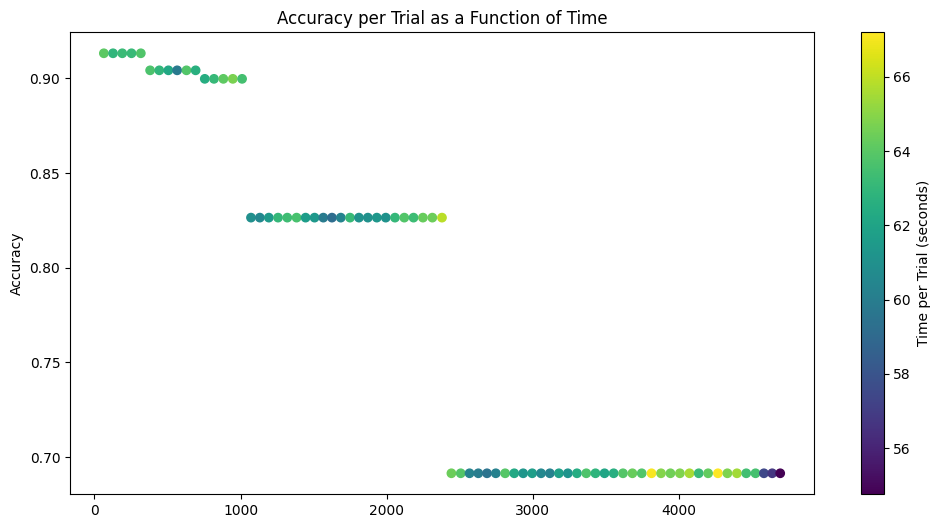

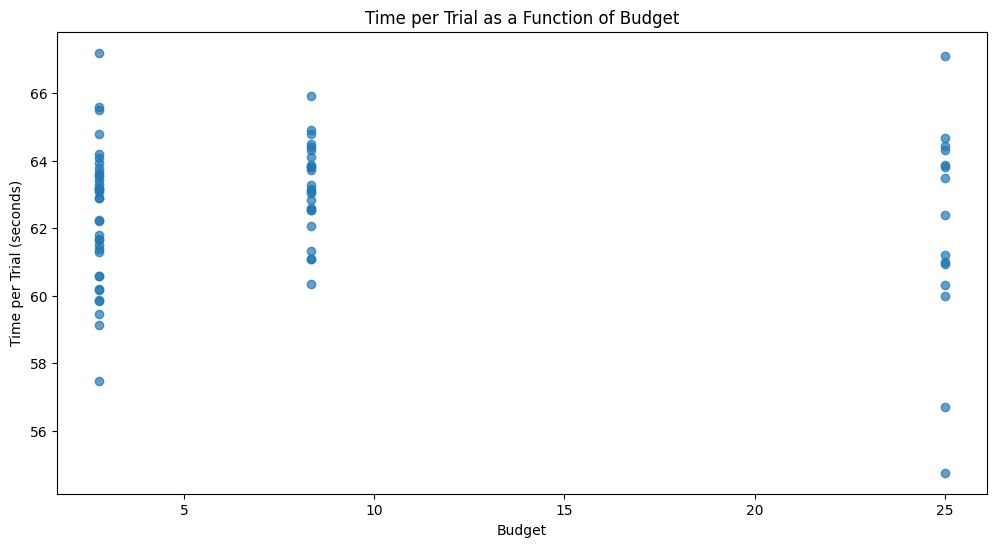

In [33]:
import json

# f = open('smac3_output\\37512afe2414205597b078349da12853\\0\\runhistory.json')
f = open('smac_hyperband_output_1hr_only/f60ff3e75e95ba86eb3154d1cfe20106/0/runhistory.json')
runhistory = json.load(f)

# Reinitialize lists for plotting with corrected parsing
trial_times = []  # Start times for each trial
trial_accuracies = []  # Inverted costs for accuracy
trial_durations = []  # Duration of each trial
trial_budgets = []  # Budgets for each trial

# Parse the corrected structure of runhistory
for entry in runhistory['data']:
    # Extracting elements from each entry
    _, _, _, budget, cost, duration, _, start_time, _, _ = entry
    
    # Invert cost to get accuracy
    accuracy = cost
    
    trial_times.append(start_time)
    trial_accuracies.append(accuracy)
    trial_durations.append(duration)
    trial_budgets.append(budget)

# Sort trials by start time for sequential plotting
sorted_indices = sorted(range(len(trial_times)), key=lambda k: trial_times[k])
sorted_accuracies = [trial_accuracies[i] for i in sorted_indices]
sorted_durations = [trial_durations[i] for i in sorted_indices]
sorted_budgets = [trial_budgets[i] for i in sorted_indices]

# Plot Accuracy per Trial as a Function of Time
plt.figure(figsize=(12, 6))
# plt.scatter(range(len(sorted_accuracies)), sorted_accuracies, c=sorted_durations, cmap='viridis')

# Convert absolute timestamps to relative times (with the first trial starting at time 0)
relative_start_times = [time - trial_times[sorted_indices[0]] for time in trial_times]
sorted_relative_start_times = [relative_start_times[i] for i in sorted_indices]

# Calculate cumulative relative times
cumulative_relative_times = [sorted_relative_start_times[0]]  # Start with the first trial's relative start time
for i in range(1, len(sorted_relative_start_times)):
    # The cumulative time at each trial is the max of the previous cumulative time or the current trial's start time
    # plus the current trial's duration to include the trial's full time span
    cumulative_relative_times.append(max(cumulative_relative_times[i-1], sorted_relative_start_times[i] + sorted_durations[i]))

peak_accuracies = []
# Initialize the first peak accuracy as the first trial's accuracy
current_peak = sorted_accuracies[0]
peak_accuracies.append(current_peak)

# Iterate through the sorted accuracies to find the peak accuracy at each trial
for acc in sorted_accuracies[1:]:
    # Update the current peak if the current trial's accuracy is higher
    current_peak = min(current_peak, acc)
    peak_accuracies.append(current_peak)

dur_cumsum = np.cumsum(sorted_durations)
print(cumulative_relative_times[-1])
plt.scatter(dur_cumsum, peak_accuracies, c=sorted_durations, cmap='viridis') #cumulative_relative_times
# plt.plot(cumulative_relative_times, peak_accuracies)#, c=sorted_durations, cmap='viridis') #cumulative_relative_times
print(cumulative_relative_times[0], cumulative_relative_times[1])
print(dur_cumsum[0], dur_cumsum[-1])

plt.colorbar(label='Time per Trial (seconds)')
# plt.xlabel('Trial Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Trial as a Function of Time')
plt.show()

# Plot Time per Trial as a Function of Budget
plt.figure(figsize=(12, 6))
plt.scatter(sorted_budgets, sorted_durations, alpha=0.7)
plt.xlabel('Budget')
plt.ylabel('Time per Trial (seconds)')
plt.title('Time per Trial as a Function of Budget')
plt.show()

In [34]:
smac_opt_time = 6069391102.0*(10**-7)
print(smac_opt_time)

606.9391102


In [ ]:
with open('smac_results_2h.txt', "r") as f:
   data = f.readlines()


Time = []
cnt = 0
for line in data:
    cnt += 1
    if "Time: " in line:
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        if numbers:
            # print(float(numbers[3]))
            t = float(numbers[3])
            Time.append(t)

print("sum time:", np.sum(Time))
print("avg time:", np.mean(Time))
print("Total number of trials:", cnt)

sum time: 4466.977945458999
avg time: 58.01270059037661
Total number of trials: 77


2024-02-06 15:25:36,277 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 142.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-02-06 15:25:36,277 - distributed.core - INFO - Event loop was unresponsive in Nanny for 142.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-02-06 15:25:36,397 - distributed.core - INFO - Event loop was unresponsive in Nanny for 142.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-02-06 15:25:36,398 - distributed.core - INFO - Event loop was unresponsive in Nanny for 142.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-02-06 15:25:36,399 - distributed.core - INFO - Even